# I. Introduction

![Simulated Annealing](SA_animation.gif)

Simulated annealing (SA) is a probabilistic technique for approximating the global optimum of a given function. Specifically, it is a metaheuristic to approximate global optimization in a large search space. It is often used when the search space is discrete (e.g., all tours that visit a given set of cities). For problems where finding an approximate global optimum is more important than finding a precise local optimum in a fixed amount of time, simulated annealing may be preferable to alternatives such as gradient descent. This notion of slow cooling implemented in the simulated annealing algorithm is interpreted as a slow decrease in the probability of accepting worse solutions as the solution space is explored. Accepting worse solutions is a fundamental property of metaheuristics because it allows for a more extensive search for the global optimal solution. In general, the simulated annealing algorithms work as follows. At each time step, the algorithm randomly selects a solution close to the current one, measures its quality, and then decides to move to it or to stay with the current solution based on either one of two probabilities between which it chooses on the basis of the fact that the new solution is better or worse than the current one. During the search, the temperature is progressively decreased from an initial positive value to zero and affects the two probabilities: at each step, the probability of moving to a better new solution is either kept to 1 or is changed towards a positive value; instead, the probability of moving to a worse new solution is progressively changed towards zero. This work implementing simulated annealing to solve the Traveling Salesman Problem (TSP) between US state capitals. Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

In [1]:
import json
import copy

import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

## II. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [3]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time. [Norvig, AIMA Chapter 3]
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
        
    Notes
    -----
        Modify the termination condition to return when the temperature
        falls below some reasonable minimum value (e.g., 1e-10) rather than
        testing for exact equality to zero
        
    Reference.
    --------
    AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    """
    t = 0
    # Current = current state of game.
    current = problem
    while True:
        t += 1
        temp = schedule(t)
        if temp < 1e-10:
            return current
        next_node = random.choice(current.successors())
        delta = next_node.get_value() - current.get_value()
        if delta > 0:
            current = next_node
        elif np.exp(delta / temp) > random.uniform(0.0, 1.0):
            current = next_node

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [4]:
import math

class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Students should only need to implement or modify the successors() and
    get_values() methods.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        result = []
        for i in range(0,len(self.path)):
            next_path = self.path[:]
            temp = next_path[i]
            if i == len(self.path) - 1:
                next_path[i] = next_path[0]
                next_path[0] = temp
            else:
                next_path[i] = next_path[i+1]
                next_path[i+1] = temp
            result.append(TravelingSalesmanProblem(next_path))
        return result
            

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  Since
        the default simulated annealing algorithm seeks to maximize the objective
        function, return -1x the path length. (Multiplying by -1 makes the smallest
        path the smallest negative number, which is the maximum value.)
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city
            
            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """
        total_distance = 0.0
        coordinates = self.coords
        for i in range(len(coordinates)):
            j = i - 1
            if i == 0:
                j = len(coordinates)-1
            a = (coordinates[i][0] - coordinates[j][0])**2
            b = (coordinates[i][1] - coordinates[j][1])**2
            total_distance += np.sqrt(a + b)
        return total_distance * -1.0

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [5]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [6]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [7]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## IV. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

In [8]:
# These are presented as globals so that the signature of schedule()
# matches what is shown in the AIMA textbook; you could alternatively
# define them within the schedule function, use a closure to limit
# their scope, or define an object if you would prefer not to use
# global variables
alpha = 0.95
temperature=1e4

def schedule(time):
    return(alpha**time)*temperature

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [9]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [10]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.97002624374561
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))]


## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

Initial path value: 8119.82
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0]), ('Salem', [80.0, 139.2]), ('Little Rock', [469.2, 367.2]), ('Richmond', [673.2, 293.6]), ('Jackson', [501.6, 409.6]), ('Des Moines', [447.6, 246.0]), ('Lansing', [563.6, 216.4]), ('Denver', [293.6, 274.0]), ('Boise', [159.6, 182.8]), ('Raleigh', [662.0, 328.8]), ('Atlanta', [585.6, 376.8]), ('Madison', [500.8, 217.6]), ('Indianapolis', [548.0, 272.8]), ('Nashville', [546.4, 336.8]), ('Columbia', [632.4, 364.8]), ('Providence', [735.2, 201.2]), ('Boston', [738.4, 190.8]), ('Tallahassee', [594.8, 434.8]), ('Sacramento', [68.4, 254.0]), ('Albany', [702.0, 193.6]), ('Harrisburg', [670.8, 244.0])]


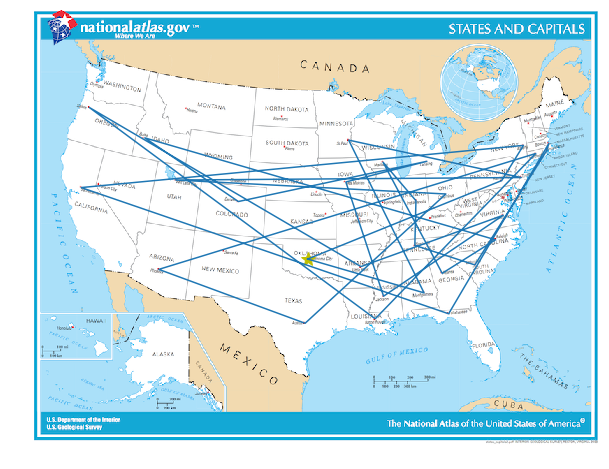

In [12]:
# Create the problem instance and plot the initial state
num_cities = 30
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

Final path length: 5663.44
[('Albany', [702.0, 193.6]), ('Boston', [738.4, 190.8]), ('Columbus', [590.8, 263.2]), ('Salt Lake City', [204.0, 243.2]), ('Oklahoma City', [392.8, 356.4]), ('Baton Rouge', [489.6, 442.0]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Trenton', [698.8, 239.6]), ('Richmond', [673.2, 293.6]), ('Madison', [500.8, 217.6]), ('Des Moines', [447.6, 246.0]), ('Salem', [80.0, 139.2]), ('Little Rock', [469.2, 367.2]), ('Jackson', [501.6, 409.6]), ('Lansing', [563.6, 216.4]), ('Raleigh', [662.0, 328.8]), ('Columbia', [632.4, 364.8]), ('Atlanta', [585.6, 376.8]), ('Sacramento', [68.4, 254.0]), ('Boise', [159.6, 182.8]), ('Denver', [293.6, 274.0]), ('Providence', [735.2, 201.2]), ('Harrisburg', [670.8, 244.0]), ('Nashville', [546.4, 336.8]), ('Montgomery', [559.6, 404.8]), ('Tallahassee', [594.8, 434.8]), ('Indianapolis', [548.0, 272.8]), ('Saint Paul', [451.6, 186.0])]


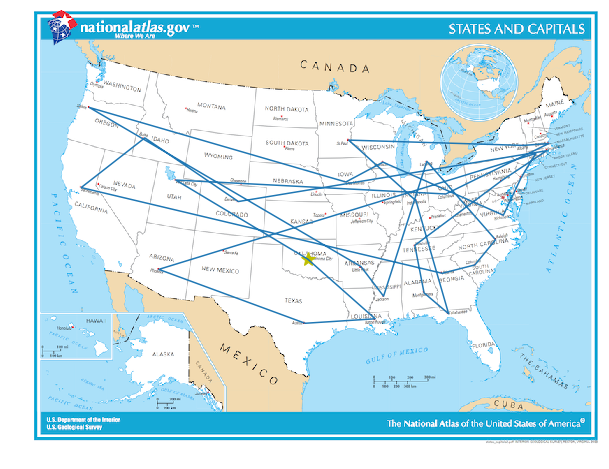

In [14]:
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

## VI. Try different time

In [46]:
import time
from tqdm import tqdm
alpha = 0.95
temperature=1e6
value_list=[]
time_list=[]

for num_cities in tqdm(range(1,len(capitals_list)+1)):
    for j in range(0,10):
        tempList=[]
        tempValueList=[]
        start=time.time()
        capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
        result = simulated_annealing(capitals_tsp, schedule)
        end = time.time()
        tempValueList.append(-result.get_value())
        tempList.append(end-start)
    
    value_list.append(sum(tempValueList)/len(tempValueList))
    time_list.append(sum(tempList)/len(tempList))

100%|███████████████████████████████████████████████████████| 30/30 [03:25<00:00, 17.00s/it]


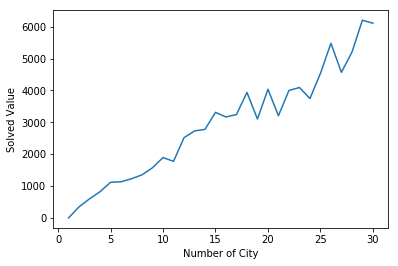

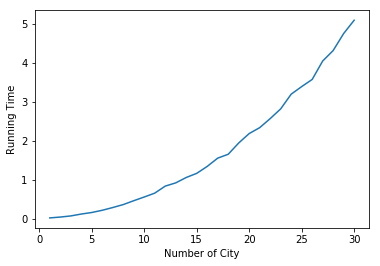

In [50]:
value_list=np.array(value_list)
time_list=np.array(time_list)
cityNum=np.array([i for i in range(1,len(capitals_list)+1)])
plt.figure();plt.xlabel("Number of City");plt.ylabel("Solved Value");plt.plot(cityNum,value_list)
plt.figure();plt.xlabel("Number of City");plt.ylabel("Running Time");plt.plot(cityNum,time_list)

## VII. On different alpha and temperature parameters.

## VIII. On different schedule function.

## IX. On different successors function.

## X. On different distance metric.